# Figure 5: Lead time performance

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @author: Manuel Pirker

## Imports

In [2]:
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias

import numpy as np
import pandas as pd

import json


## Functions

In [3]:
def load_metrics(path):
    with open(path, "r") as f:
        metrics = json.load(f)
    return metrics

## Create model class

In [4]:
class Model:
    def __init__(self, name, model_folder, n_trial=-1, target_name="", feat_hindcast=[], feat_forecast=[], is_external_model= False, is_final_model= False, color="r", ls="-"):
        self.name  = name
        self.color = color
        self.ls    = ls
        self.is_external_model = is_external_model
        
        if is_final_model:
            self.lg_path = model_folder
            self.hp_path = model_folder
            if is_external_model:
                is_external_model
                # do nothing
            else:
                with open(os.path.join(self.lg_path, "features.txt"), "r") as f:
                    dic = json.load(f)
                self.target_name   = dic["target_name"]
                self.feat_hindcast = dic["feat_hindcast"]
                self.feat_forecast = dic["feat_forecast"]
        else:
            self.lg_path = os.path.join(model_folder, "logs", f"trial_{n_trial:02d}")
            self.hp_path = os.path.join(model_folder,  "hp", f"trial_{n_trial:02d}")
            self.target_name   = target_name
            self.feat_hindcast = feat_hindcast
            self.feat_forecast = feat_forecast

models = {
    "arima": Model("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "k",
                ls = "--",
                  ),
    "lstm_pbhm": Model("HLSTM-PBHM",
                           r"rst\HLSTM-PBHM",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          ),
     "lstm": Model("HLSTM",
                   r"rst\HLSTM",
                   is_final_model = True,
                   color = "#ff7f00",
                   ls = "-",
                 ),
     }
    

## Init

In [5]:
# path
PLOT_PATH = r"plots"
DATA_PATH = r"data\Dataset.csv"

# set plot parameters
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

## Main

In [6]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "kge":  calculate_kge(dfp.qmeasval.values, dfp.qsim.values),
          "nse":  calculate_nse(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

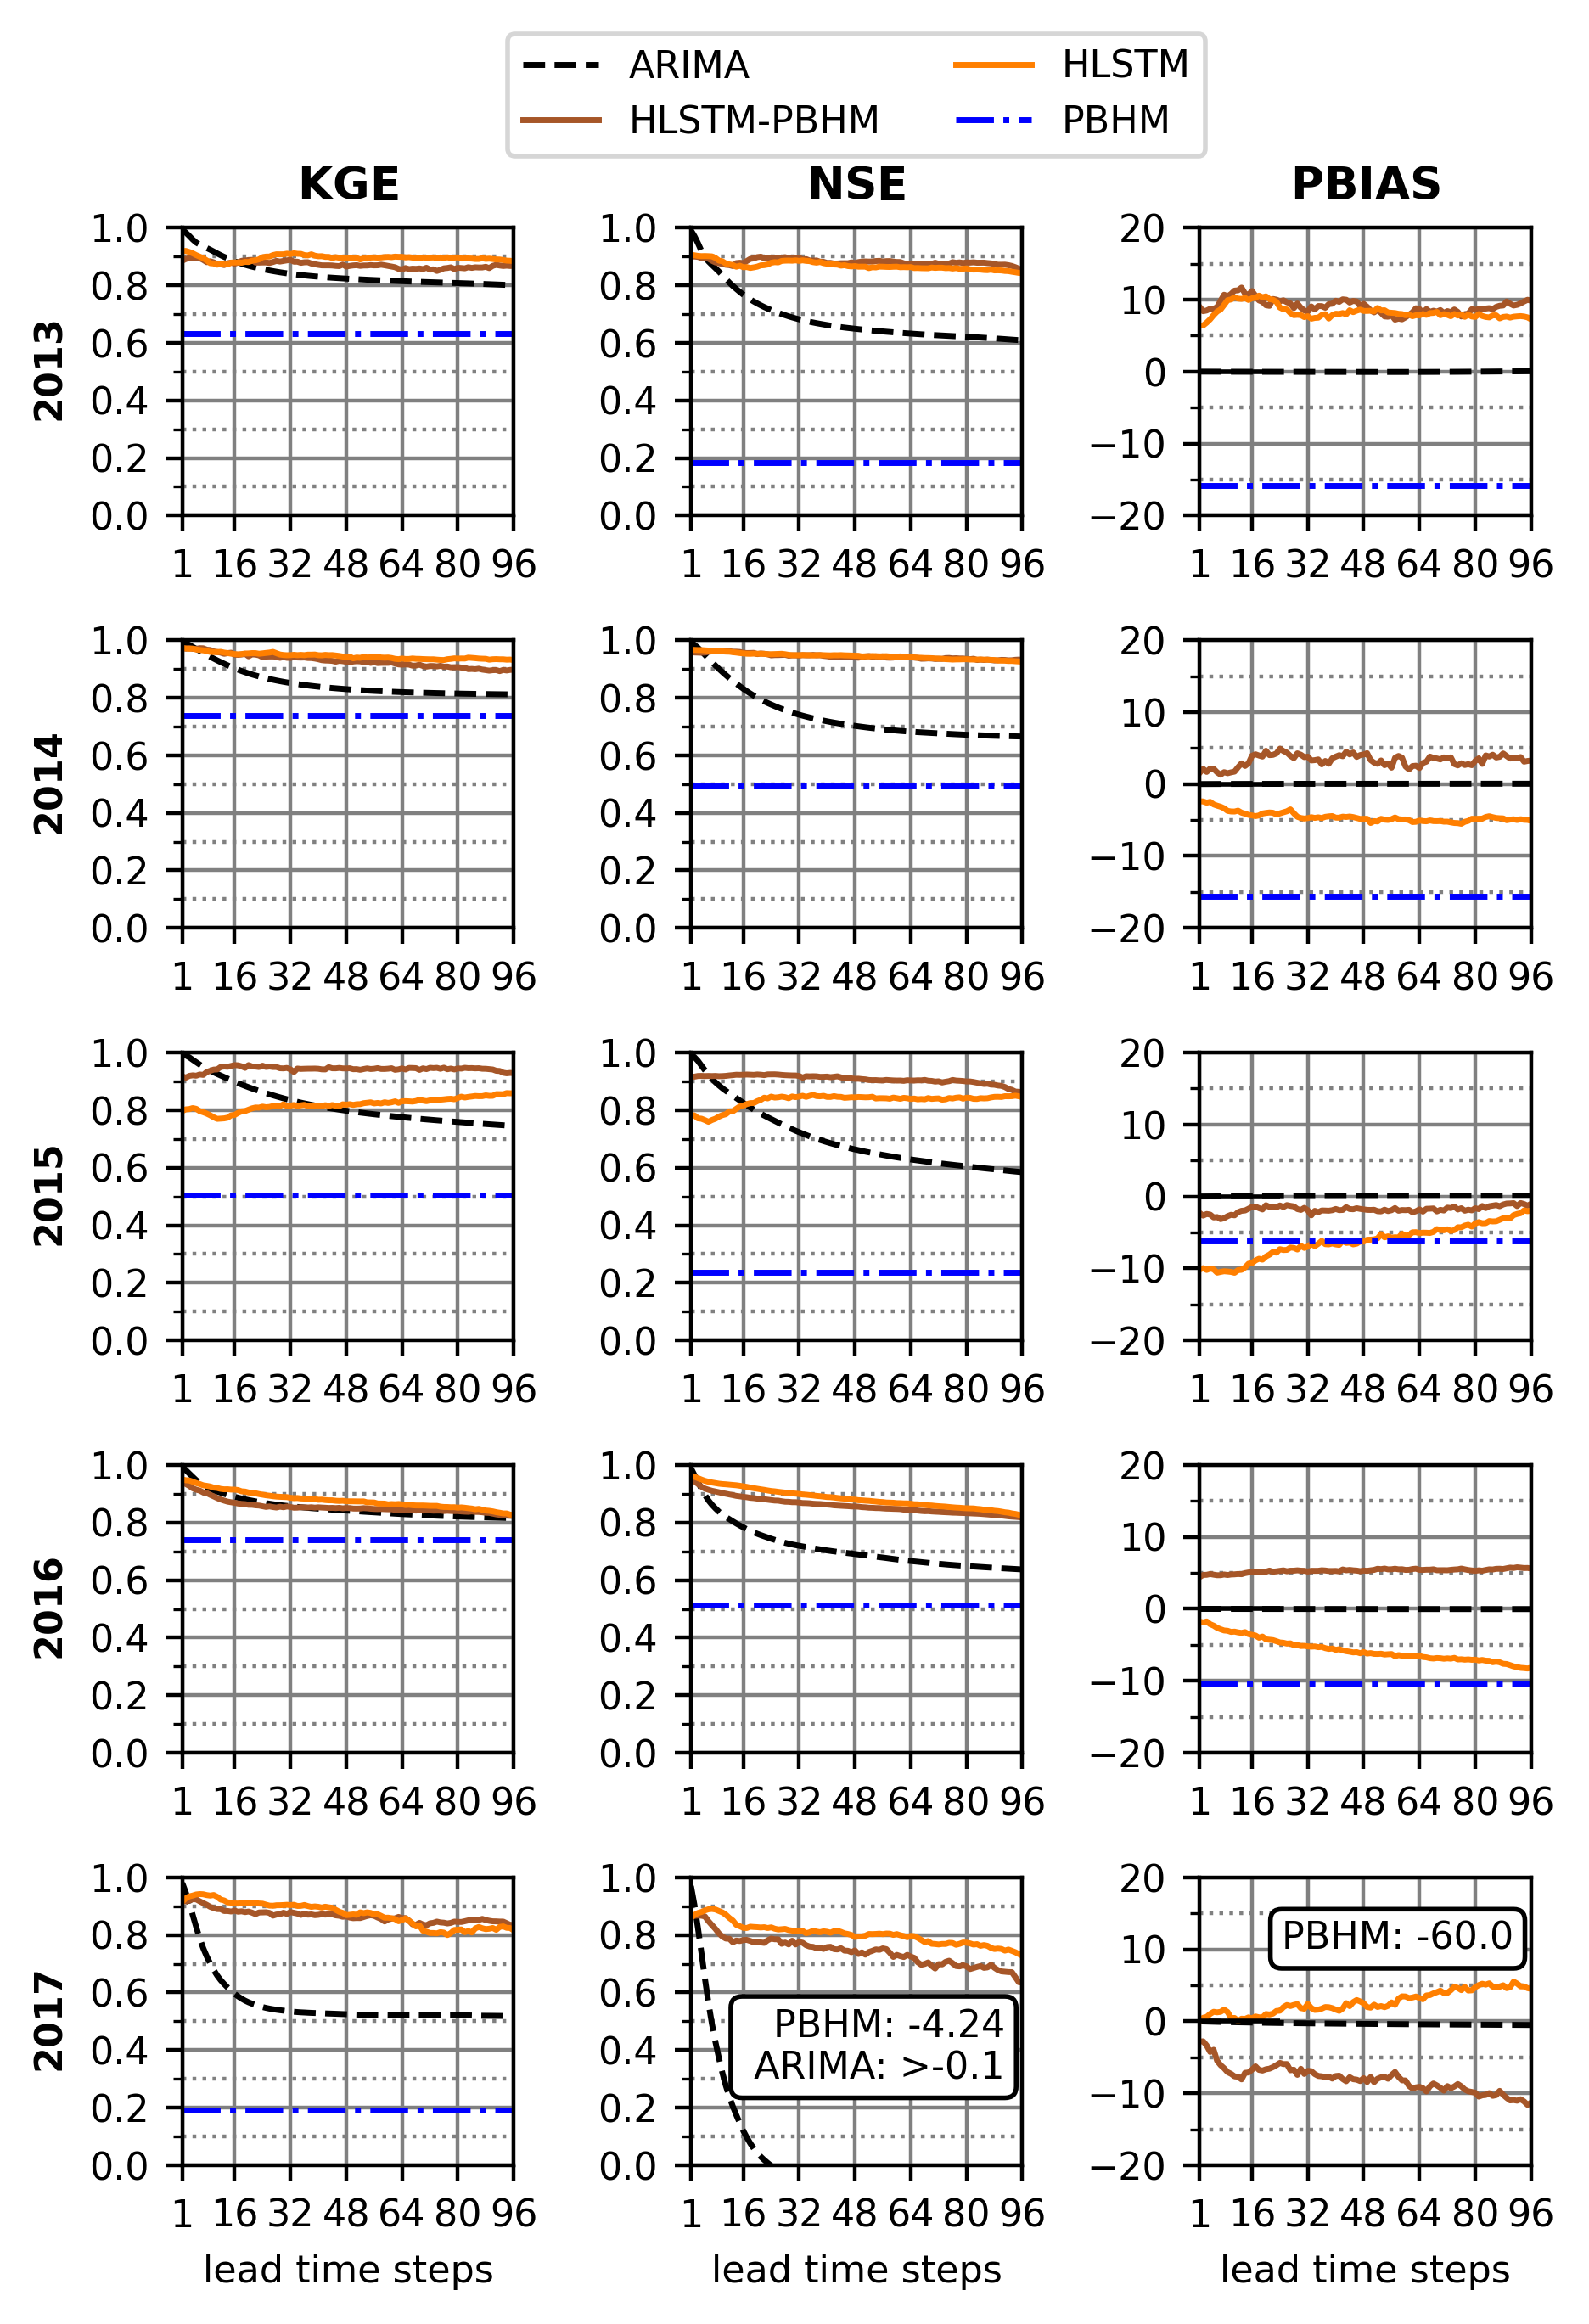

In [7]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["kge", "nse", "bias"]
metric_labels = ["KGE", "NSE", "PBIAS"]
ylims = [(0,1), (-2,1), (-20,10)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "kge_pass", "nse_pass", "bias_pass",
                           "kge_min", "kge_avg", "kge_max", 
                           "nse_min", "nse_avg", "nse_max", 
                           "bias_min", "bias_avg", "bias_max"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics.txt"))
    
    n_row += 5
    for j, met in enumerate(metric_names):
        metric  = metrics["test"][met]
        for i in range(5):
            df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                           np.mean(metric[i]), 
                                                                           np.max(metric[i])]
            df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
            xx = np.arange(1,np.array(metric[i]).shape[0]+1)
            axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)
 

for i in range(5):
    for j in range(3):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")

        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "-.", label="PBHM", lw=1.25)
        if (i == 4) & (j == 1):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,0.3, f"PBHM: {metric_hyd:4.2f}\n ARIMA: >-0.1", color="k", ha="right",
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,10, f"PBHM: {metric_hyd:4.1f}", color="k", ha="right",
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               })
            
            
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        if j == 2:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(5))
            axes[i,j].set_ylim((-20,20))
            axes[i,j].hlines(0, 0, 24, color="k", lw=1)
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(0.2))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
            axes[i,j].set_ylim((0,1))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(0.5, 1.25), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [8]:
fig.savefig(os.path.join(PLOT_PATH, 'fig5_leadtime_performance.png'), bbox_inches="tight", dpi=300)